# DSGA 1007 Final Project
### Yue Jin, yj1672; Isabel Zhou, yz6126; Dian Zhang, dz584

This project focuses on helping the restaurant in big cities (Toronto in this study) to better implement strategies for opening new branches by using a human-centric & urban city data analytic approaches. 

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plot
import matplotlib.cm as cmx
import matplotlib.colors as colors
import geopandas as gpd
from shapely.geometry import Point
import pylab as pl
%pylab inline

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/Volumes/COSMOS/ProgramFiles/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 1. Introduction

Due to high rent prices and fiercely competitive business environment in large cities, there are new restaurants opening up and old ones closing down all the time. We are willing to develop business strategy for restaurants in a large city, and help management make a better decision to select the location of the restaurant’s next chain. In this study, we chose the fast food chain McDonald’s in the city of Toronto as our research sample. There are several factors are considered to generate our strategy:

    1. Location of restaurants
    2. Proximity to surroundings
    3. Transit availability of restaurant

## 2. Methodology

### Data

The major dataset we used is the Business data from Yelp. It contains roughly 200K different business including restaurants, bars, etc operating in North America. It has columns of basic attributes of a business such as name, address, business categories, working hours, etc.

As our study is focused on the city of Toronto, we first extracted all business data in Toronto from the dataset by filtering the ‘city’ column. It helped to reduce the data size we interact with and increased analyzing speed. Also, because in the following study, we would cluster the different McDonald's restaurants by the attributes of its location and surrounding neigbourhood, we created dataframes that contain only the latitude and longitude coordinates of each McDonald's and rival fast food restaurants. The other columns such as business categories and working hours are the same across all McDonald's which would not help in cluster creation, and thus they were excluded from the dataset.

In [5]:
# Read in Yelp business data in JSON format, and filter down to city of Toronto
bus = pd.read_json('business.json', orient='columns', lines = True)
# create df with only Toronto businesses 'tor'
tor = bus[bus['city'] == "Toronto"]
#tor = pd.read_csv('tor.csv')

In [6]:
# check the fastfood restaurants in df
# tor[tor['categories'].str.contains('Fast Food')==True]['name'].value_counts()

###  Bussiness-oriented Spatial Exploration

Our study target is McDonalds. Firstly, take an outlook of fast food restaurants in the city of Toronto, and we can get an roughly intuitive impression about current spatial relationship of Toronto restaurants. 


Text(0.5, 1, 'Restaurants in Toronto')

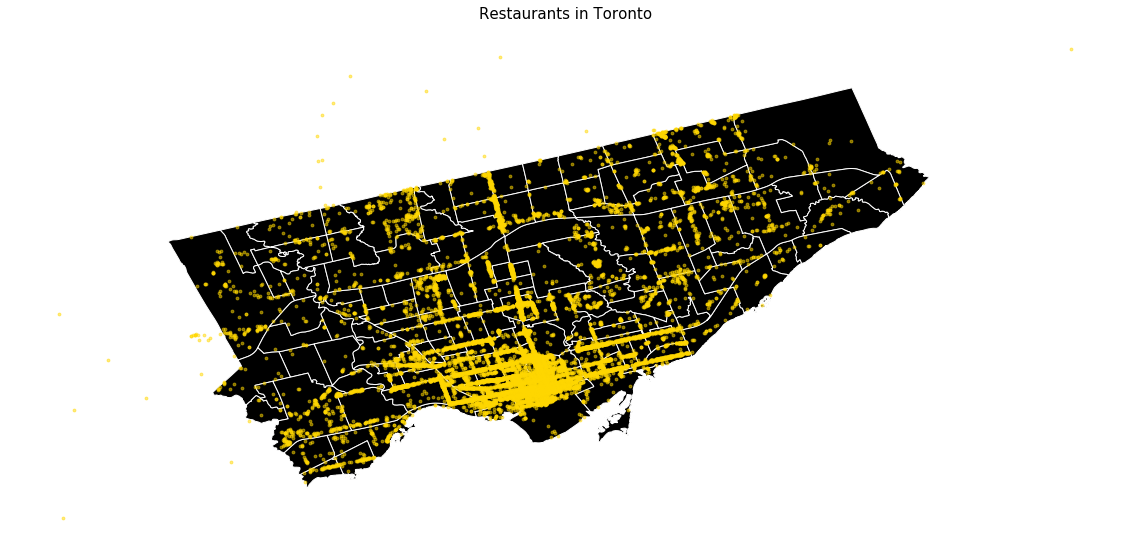

In [7]:
shp = gpd.read_file('Neighbourhoods.shp')
shp_wgs = shp.to_crs({'init': 'epsg:4326'})

tor_ = tor.copy()
tor_['geometry'] = (list(zip(tor_['longitude'], tor_['latitude'])))
tor_['geometry'] = tor_.geometry.apply(lambda x: Point(x))
res_point = gpd.GeoDataFrame(tor_, geometry='geometry')

# visualize restaurants points
fig = pl.figure(figsize = (20,20))
ax = fig.add_subplot(111)
shp_wgs.plot(ax=ax, color='black', edgecolor='w')
res_point.plot(ax=ax, color='gold', alpha = 0.5, markersize=8)
ax.axis('off')
pl.title('Restaurants in Toronto', fontsize=15)

Then, considering locations of our McDonalds and their proximity to rivals, methods on finding spatial correlations can be implemented in the next step.

From visualization map, one can conclude that McDonalds have very strong and large numbers of rivals with similar and market needs and overlapped customer groups.

Filter all McDonald's restaurants, and keep only the coordinates columns

In [8]:
# filter only McDonalds restaurants
tor_mac = tor[tor['name'] == ("McDonald's" or "Mcdonalds")].copy()
tor_mac_loc = tor_mac[['business_id','latitude','longitude']]
tor_mc_c = tor_mac.copy()
tor_mc_c['geometry'] = (list(zip(tor_mc_c['longitude'], tor_mc_c['latitude'])))
tor_mc_c['geometry'] = tor_mc_c.geometry.apply(lambda x: Point(x))
mc_point = gpd.GeoDataFrame(tor_mc_c, geometry='geometry')

Filter all rival restaurants, and keep coordinates columns

In [9]:
# get rival fast food restaurant locations
tor_rivals = tor[tor['categories'].str.contains('Fast Food')==True].copy()
tor_rivals = tor_rivals[tor['name'] != ("McDonald's" or "Mcdonalds")].copy()
tor_rivals_loc = tor_rivals[['business_id','latitude','longitude']]
tor_rivals['geometry'] = (list(zip(tor_rivals['longitude'], tor_rivals['latitude'])))
tor_rivals['geometry'] = tor_rivals.geometry.apply(lambda x: Point(x))
rivals_point = gpd.GeoDataFrame(tor_rivals, geometry='geometry')

Text(0.5, 1, 'Mcdonalds & Competitors in Toronto')

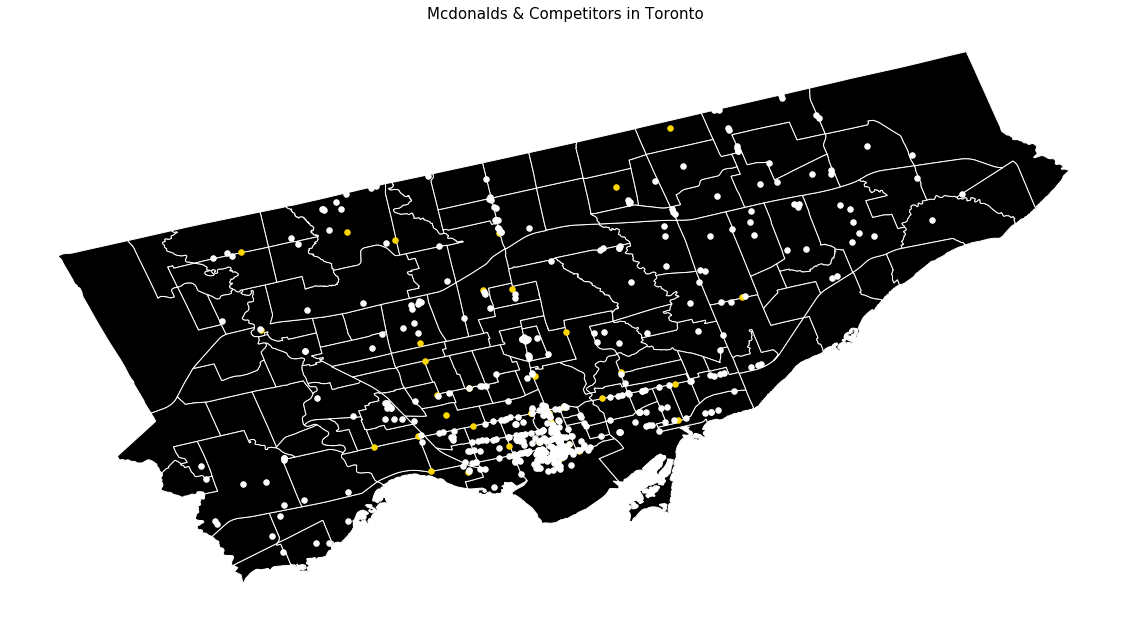

In [10]:
# visualize mcdonalds points
fig = pl.figure(figsize = (20,20))
ax = fig.add_subplot(111)
shp_wgs.plot(ax=ax, color='black', edgecolor='w')
mc_point.plot(ax=ax, color='gold', alpha = 1, markersize=30)
rivals_point.plot(ax=ax, color='white', alpha = 1, markersize=30)
ax.axis('off')
pl.title('Mcdonalds & Competitors in Toronto', fontsize=15)

### Tools - Arcgis

- Help to find rivals around the range of 2000 meters for each McDonalds

From the perspective of customer needs and marketing feedbacks, we select rivals in the range of 2km per McDonalds of Toronto. This pictures shows density of rivals proximity to each McDonalds, and we will use this filterd data to do the following study. 

In [12]:
# Arcgis - find 2km nearest competents per mcdonalds
rivals_2km = pd.read_csv('2km_rivals_near_mcdonalds.csv',header = None, error_bad_lines=False)
rivals_2km_ = rivals_2km.iloc[:,3:13]
rivals_2km_new = rivals_2km_.rename(columns = {3:'name',4:'address',5: 'city',6:'state',7:'postal_code',8:'latitude',9:'longitude',10:'stars',11:'review_count',12:'is_open'})
rivals_2km_new = rivals_2km_new.drop(index = 0)
rivals_2km_new[['latitude','longitude']] = rivals_2km_new[['latitude','longitude']].values.astype('float')
len(rivals_2km_new)

389

Text(0.5, 1, 'Mcdonalds & 2km Nearest Competitors in Toronto')

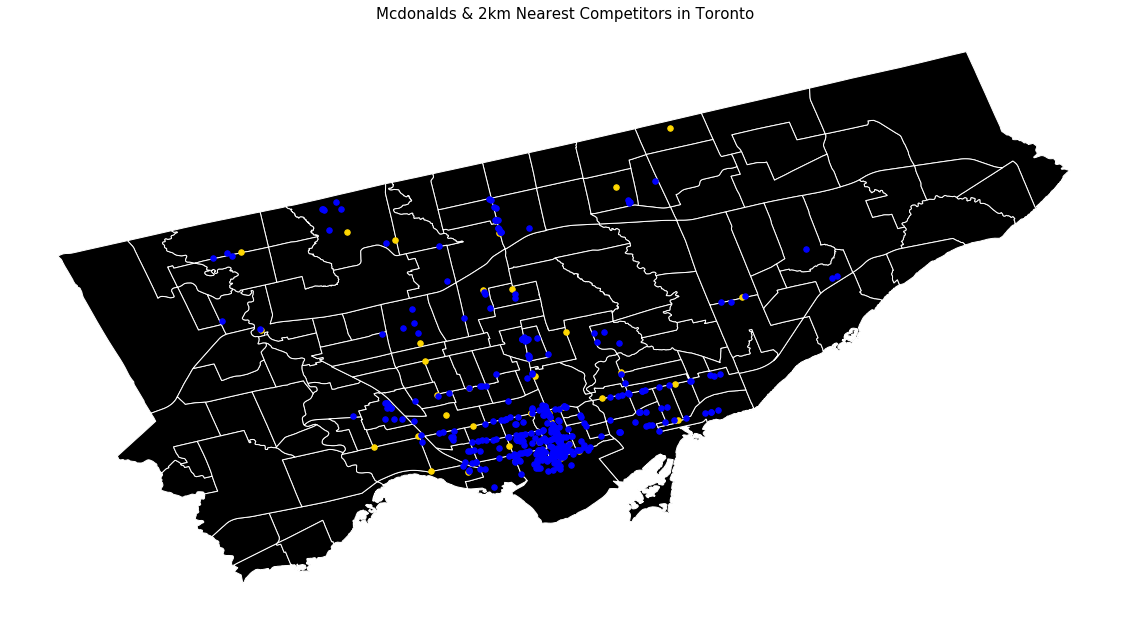

In [13]:
rivals_2km_new['geometry'] = (list(zip(rivals_2km_new['longitude'], rivals_2km_new['latitude'])))
rivals_2km_new['geometry'] = rivals_2km_new.geometry.apply(lambda x:Point(x))
rivals_2km_new_point = gpd.GeoDataFrame(rivals_2km_new, geometry='geometry')

# visualize 2km nearseast competitors
fig = pl.figure(figsize = (20,20))
ax = fig.add_subplot(111)
shp_wgs.plot(ax=ax, color='black', edgecolor='w')
mc_point.plot(ax=ax, color='gold', alpha = 1, markersize=30)
rivals_2km_new_point.plot(ax=ax, color='b', alpha = 1, markersize=30)
ax.axis('off')
pl.title('Mcdonalds & 2km Nearest Competitors in Toronto', fontsize=15)

We build networks between each McDonalds and rivals nearby. For each McDonald, finding nearset restaurants in the range of 2km and connect with them. After calculation, spatial correlation has been concluded from pictures:

- Obviously, boroughs with large numbers of restaurants are competitive and dense in numbers. These fast food restaurants are located in similar streets.
- In general, restaurants which are remote from the center of city, are more likely to have fewer competitors in the same area.
- However, there are still some outliers in results. Some McDonalds locate nearby city center, but have fewer competitors.

#### Base on spatial correlation theory and practice, it will be a great direction to do clustering and explore more.

In [14]:
lines_2km = pd.read_csv('2km_Connecting Lines.csv',header = None, error_bad_lines=False)
lines_2km_ = pd.merge(lines_2km.iloc[:,6:13],lines_2km.iloc[:,17:24],left_index = True,right_index = True)
lines_2km_new = lines_2km_.rename(columns = {6:'Mc_Name',7:'Mc_Address',8:'Mc_City',9:'Mc_State',10:'Mc_postal_code',11:'Mc_Lat',12:'Mc_Lon',
                                            17:'Rival_Name',18:'Rival_Address',19:'Rival_City',20:'Rival_State',21:'Rival_postal_code',22:'Rival_Lat',23:'Rival_Lon'})
lines_2km_new = lines_2km_new.drop(index = 0)
lines_2km_new[['Mc_Lat','Mc_Lon','Rival_Lat','Rival_Lon']] = lines_2km_new[['Mc_Lat','Mc_Lon','Rival_Lat','Rival_Lon']].values.astype('float')

In [16]:
#create a network with restaurants names as nodes
import networkx as nx
McPoints=nx.Graph()
RivalPoints=nx.Graph()
McPoints.add_nodes_from(lines_2km_new['Mc_Address'])
RivalPoints.add_nodes_from(lines_2km_new['Rival_Name'])

In [17]:
allRes = lines_2km_new['Mc_Address'].append(lines_2km_new['Rival_Name'], ignore_index=True)

In [18]:
ResPoints = nx.Graph()
ResPoints.add_nodes_from(allRes)

In [19]:
McPos = {lines_2km_new['Mc_Address'].values[i]:(lines_2km_new['Mc_Lon'][i],lines_2km_new['Mc_Lat'][i])
         for i in range(1,len(lines_2km_new))}
RivalPos = {lines_2km_new['Rival_Name'].values[i]:(lines_2km_new['Rival_Lon'][i],lines_2km_new['Rival_Lat'][i])
         for i in range(1,len(lines_2km_new))}

In [20]:
ResPos = {**McPos,**RivalPos}

In [21]:
#create a list of edges of connected restaurants
EN=len(lines_2km_new)
edgelist=[(lines_2km_new['Mc_Address'][j],lines_2km_new['Rival_Name'][j]) for j in range(1,EN)]

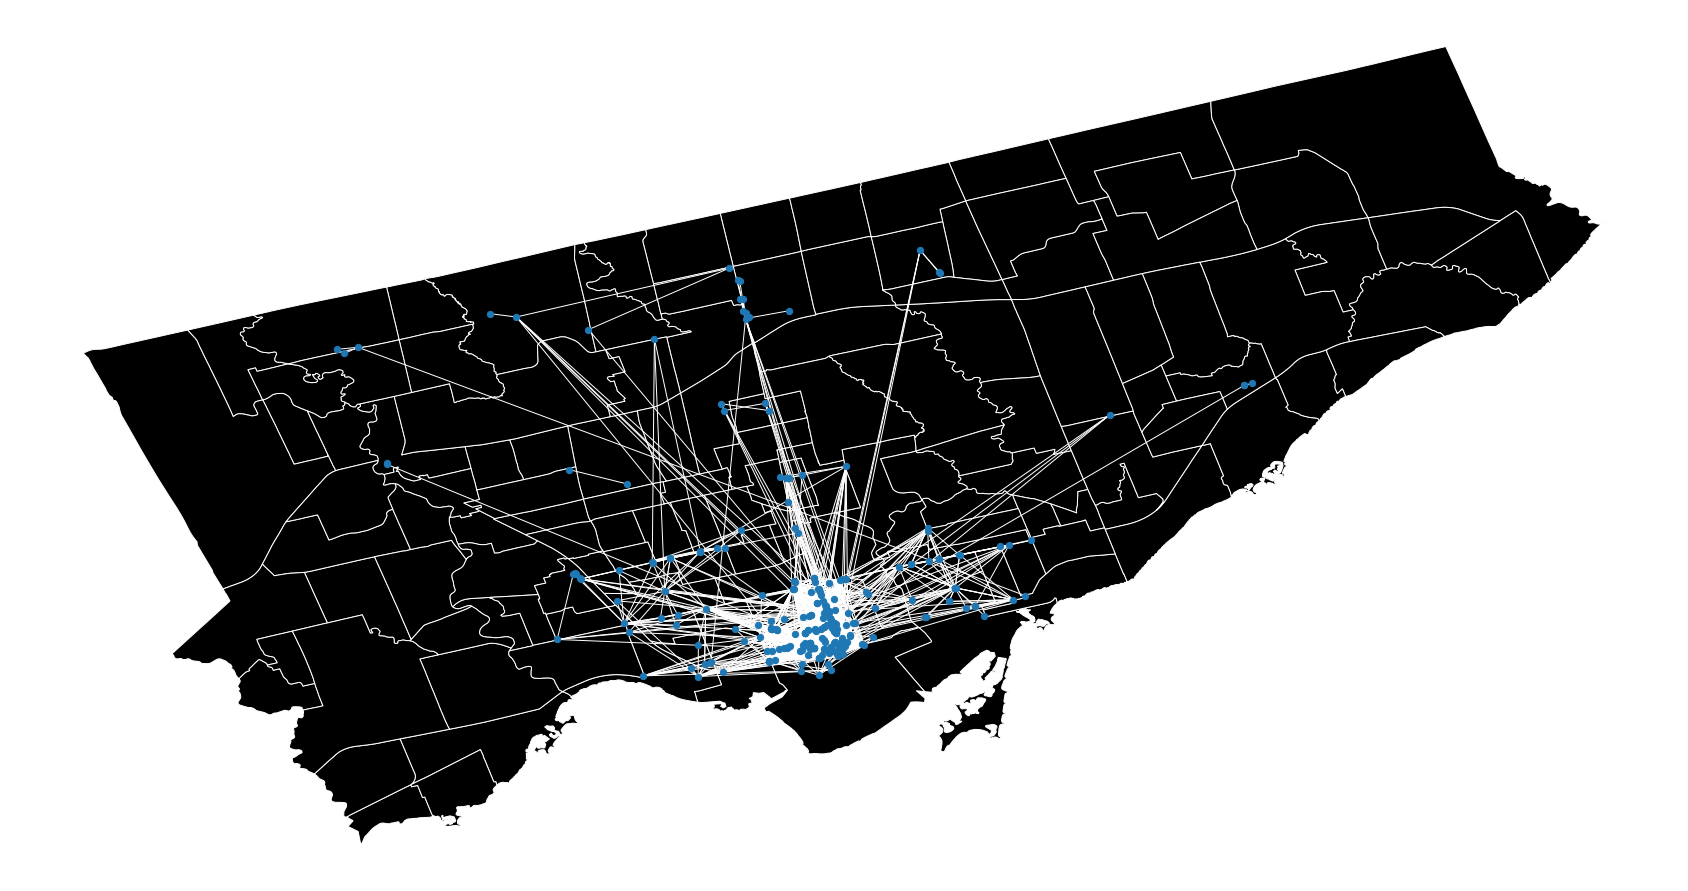

In [22]:
fig = pl.figure(figsize = (30,30))
ax = fig.add_subplot(111)
shp_wgs.plot(ax=ax, color = 'black', edgecolor='w')
ResPoints.add_edges_from(edgelist)
nx.draw(ResPoints,pos=ResPos,with_labels=False,node_size=40,edge_color='white',arrows = True)

To be explicit, we filter data and find McDonalds with most and least competitors. The top 1 most competitive McDonalds is located in 160 Spadina Aveue, with 81 competitors. The least one is located in 2781 Dufferin Street, with 1 competitor in the range of 2km.

Thus, from this study on spatial correlation between McDonalds with their rivals, we found out something interesting, and want to take more factors into considerations, eventually providing a better business advice on site selection.

In [23]:
#Top mcdonalds with most competitors
ResDeg=dict(ResPoints.degree())
TopMc=list(ResDeg.keys())[np.argmax(list(ResDeg.values()))]
print('The top 1 competitive McDonalds is {0} with {1} competitors'.format(TopMc,ResDeg[TopMc]))

The top 1 competitive McDonalds is 160 Spadina Ave with 81 competitors


In [24]:
#Last mcdonalds with least competitors
LeastMc=list(ResDeg.keys())[np.argmin(list(ResDeg.values()))]
print('Least McDonalds is {0} with {1} competitors'.format(LeastMc,ResDeg[LeastMc]))

Least McDonalds is 2781 Dufferin Street with 1 competitors


In [25]:
lines_2km_new[lines_2km_new.Mc_Address.str.contains('160 Spadina Ave')]
lines_2km_new[112:113]

,Mc_Name,Mc_Address,Mc_City,Mc_State,Mc_postal_code,Mc_Lat,Mc_Lon,Rival_Name,Rival_Address,Rival_City,Rival_State,Rival_postal_code,Rival_Lat,Rival_Lon
113,McDonald's,160 Spadina Ave,Toronto,ON,M5T 2C2,43.6488,-79.3967,Popeyes Louisiana Kitchen,400 Queen Street W,Toronto,ON,M5V 2A6,43.6488,-79.3972


In [26]:
lines_2km_new[lines_2km_new.Mc_Address.str.contains('2781 Dufferin Street')]
lines_2km_new[970:971]

,Mc_Name,Mc_Address,Mc_City,Mc_State,Mc_postal_code,Mc_Lat,Mc_Lon,Rival_Name,Rival_Address,Rival_City,Rival_State,Rival_postal_code,Rival_Lat,Rival_Lon
971,McDonald's,2781 Dufferin Street,Toronto,ON,M6B 3R9,43.7049,-79.4523,NaN,2957 Dufferin Street,Toronto,ON,M6B 3T1,43.7101,-79.4534


In [27]:
MostMc = nx.Graph()
MostMc.add_nodes_from(lines_2km_new[112:113]['Mc_Address'])

LeastMc = nx.Graph()
LeastMc.add_nodes_from(lines_2km_new[970:971]['Mc_Address'])

two_pos = {'160 Spadina Ave':(float(lines_2km_new.iloc[112:113,6]),float(lines_2km_new.iloc[112:113,5])),
          '2781 Dufferin Street':(float(lines_2km_new.iloc[970:971,6]),float(lines_2km_new.iloc[970:971,5]))}

{'160 Spadina Ave': Text(-79.396742, 43.648782, '160 Spadina Ave')}

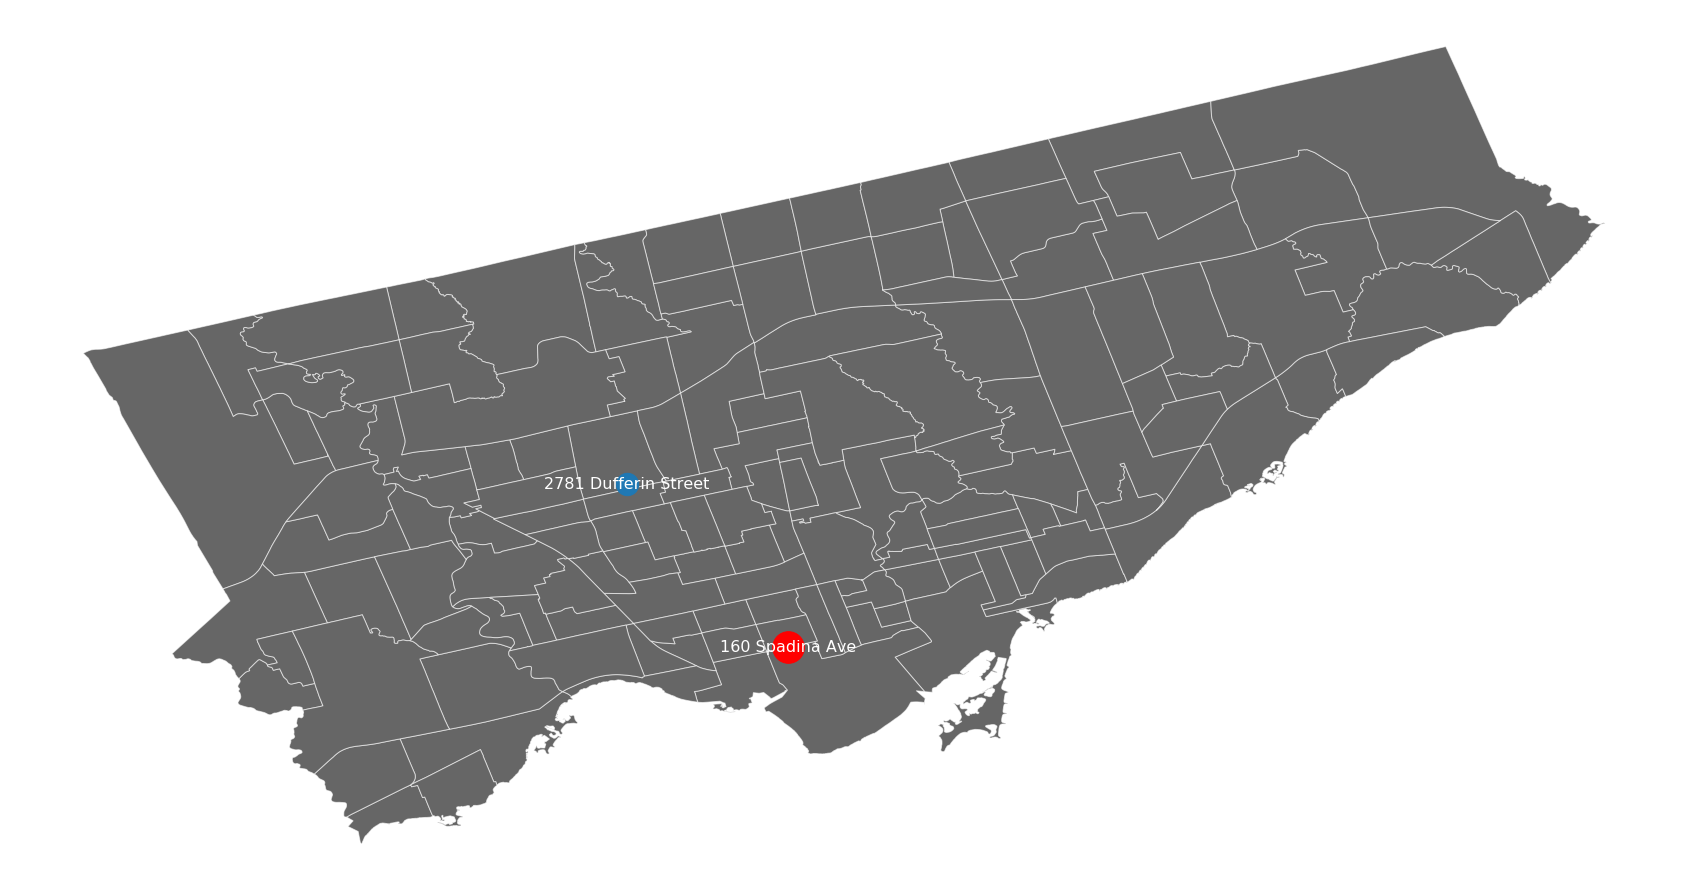

In [28]:
fig = pl.figure(figsize = (30,30))
ax = fig.add_subplot(111)
shp_wgs.plot(ax=ax, color='black',alpha = 0.6,edgecolor='w')
nx.draw(MostMc,pos=two_pos,node_size=1000,node_color='r')
nx.draw_networkx_labels(LeastMc,pos=two_pos,font_color = 'white',font_size=16)

nx.draw(LeastMc,pos=two_pos,node_size=500)
nx.draw_networkx_labels(MostMc,pos=two_pos,font_color = 'white',font_size=16)

Next, we also needed the residential and working population information in each area.

For residential, we got population by area data from City of Toronto Open Data (CTOD). The latitude and longtitude coordinates of each residential area and the resident population data reside in two different files. We loaded both files in, joined the two data set by area name, and kept only the coordinates and population columns.

In [10]:
# get residential area (neighbourhood) + location
nhh = pd.read_csv('Neighbourhoods_dz_refined.csv')
nhh = nhh.loc[:, ['AREA_NAME', 'LONGITUDE', 'LATITUDE']]
nhh['AREA_NAME'] = nhh['AREA_NAME'].apply(lambda x: re.search('(.*) \(', x).group(1))
nhh = nhh.set_index('AREA_NAME')

nhhProfile = pd.read_csv('neighbourhood-profiles-2016-csv.csv')
nhhProfile = pd.DataFrame(nhhProfile.iloc[2, :])
nhhProfile = nhhProfile.iloc[4:, :]#.set_index('Characteristic')
nhhProfile.set_axis(nhhProfile.iloc[0,:], axis=1)
nhhProfile = nhhProfile.iloc[1:,:]

In [11]:
# join neighboorhood location and population
prof = nhh.merge(nhhProfile, how='outer', left_index=True, right_index=True)
prof["Population, 2016"] = prof["Population, 2016"].str.replace(',', '').astype('float')
prof = prof.drop('City of Toronto', axis=0)
prof = prof.rename(columns={"LONGITUDE": "longitude", "LATITUDE": "latitude"})

For working population, it is hard to know how many active employees are in each area, but we strongly believe that subway ridership is proportional to the whole working population. Thus, we also obtained the data of total arrival and departure riders of each subway station from CTOD. We manually collected the latitude and longitude coordinates of each station and added them in raw data file.

Along with the residential population area data, these datasets will give us a picture of the population density near each McDonald’s.

In [12]:
# Calculate the total rider flow of each subway station
subway = pd.read_csv('ttc_subway_usage.csv', index_col = 'Rank')
subway_total = subway[['Station','Total','latitude','longitude']]
subway_total = subway_total.groupby(['Station','latitude','longitude']).sum().reset_index()

### Mathematical and Computational Methods

Firstly, we built a function to calculate the distance between two locations based on latitude and longtitude coordinates. This function would be heavily used in following project to calculate the distance such as between McDonald's restaurants and subway stations, etc.


In [13]:
# build function to calculate distance given two lat and long coordinates
import math

def distance_calc(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

We also built a function that can iterate the distance calculation between two dataframe containing location coordinates. This function also enabled to aggregate a given parameter in dataframe 2, or do a simple count, given a distance limitation between two coordinates.

In [14]:
# build function to iterate the calculation of two dfs of coordinates and agg certain value
# df1, df2: the two df of coordinates
# agg_attr: the column of df2 to be aggregated, if False then do simple count
# radius: the distance limit of aggregation

def distance_iter(df1, df2, agg_attr, radius):
    acc_list = []
    for index1, row1 in df1.iterrows():
        coord1 = (row1['latitude'], row1['longitude'])
        acc = 0
        for index2, row2 in df2.iterrows():
            coord2 = (row2['latitude'], row2['longitude'])
            dist = distance_calc(coord1,coord2)
            if dist <= radius:
                if not agg_attr:
                    acc += 1
                else:
                    acc += row2[agg_attr]
        acc_list.append(acc)
    return acc_list

### Attribute Clustering

Here we started the clustering process of each McDonalds restaurants. We first built the clusters based on the neighbourhood attributes surrounding each restaurant, including:
1. Total population of residential areas within 2km distance to each McDonald's
2. Count of all rival fastfood restaurant within 2km distance to each McDonald's
3. Count of subway stations within 1km distance to each McDonald's
4. Total riders of subway stations within 1km distance to each McDonald's

In [15]:
# Calculate residential population
acc_population_list = distance_iter(tor_mac_loc, prof, 'Population, 2016', 2000)
tor_mac['acc_population'] = acc_population_list

In [16]:
# Count rival restaurants
acc_rivals_list = distance_iter(tor_mac_loc, tor_rivals_loc, False, 2000)
tor_mac['acc_rivals'] = acc_rivals_list

In [17]:
# Calculate subway stations and riders
acc_stations_list = distance_iter(tor_mac_loc, subway_total, False, 1000)
acc_passenger_list = distance_iter(tor_mac_loc, subway_total, 'Total', 1000)
tor_mac['acc_stations'] = acc_stations_list
tor_mac['acc_passenger'] = acc_passenger_list

We used two clustering methodologies: K-means and Hierarchical Clustering. The corresponding sk-learn packages were loaded in the beginning of notebook. We experimented and started with building 3 clusters.

In [18]:
X = tor_mac[['acc_population','acc_rivals','acc_stations','acc_passenger']]

Clustering with k-means Method

In [19]:
# clustering with k-means Method
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans_labels=kmeans.labels_

Clustering with Hierarchical (Agglomerative) Method

In [20]:
# clustering with Agglomerative (Hierarchical) Method
ac_clustering = AgglomerativeClustering(n_clusters= 3).fit(X)
ac_labels = ac_clustering.labels_

Append the clustering labels to McDonald's restaurants dataframe

In [21]:
tor_mac['kmeans_cluster'] = kmeans_labels
tor_mac['ac_cluster'] = ac_labels

Check the outcome of kmeans clusters

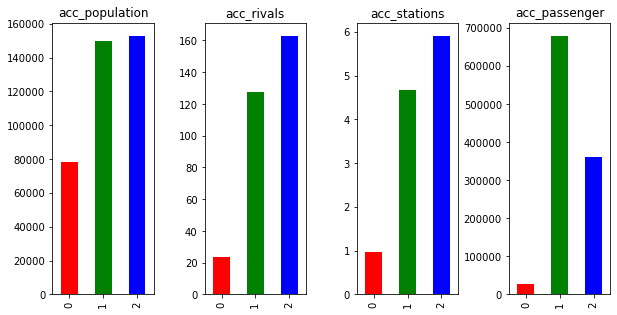

In [22]:
X = tor_mac[['acc_population','acc_rivals','acc_stations','acc_passenger']]
X['cluster'] = kmeans_labels
result = X.groupby('cluster').mean()
attr_list = ['acc_population','acc_rivals','acc_stations','acc_passenger']

fig, axes = plot.subplots(nrows=1, ncols=4, figsize = (10,5))
plot.subplots_adjust(wspace=0.5)

for idx, entry in enumerate(attr_list):
    df = result[[entry]]
    
    ax = df.plot(kind='bar', ax=axes[idx], title=entry, color = 'rgb')
    ax.set_xlabel(None)
    ax.get_legend().remove()

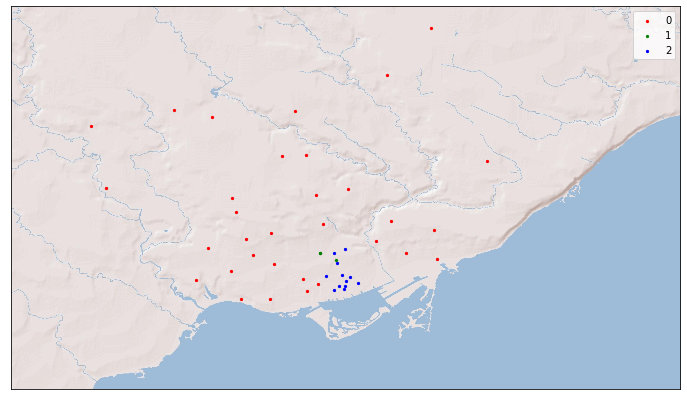

In [23]:
from mpl_toolkits.basemap import Basemap

Y = tor_mac.loc[:, ['latitude', 'longitude']]
n_clusters = len(set(kmeans_labels))
clusters = pd.Series([Y[kmeans_labels == n] for n in range(n_clusters)])

plot.figure(figsize = (12, 12))
m = Basemap(projection='merc', resolution='l', epsg = 4269, 
            llcrnrlon=-79.597,llcrnrlat=43.58, urcrnrlon=-79.16,urcrnrlat=43.83)
unique_label = np.unique(kmeans_labels)


# plot different clusters on map, note that the black dots are outliers
for i, cluster in enumerate(clusters):
    lons_select = cluster.iloc[:, 1]
    lats_select = cluster.iloc[:, 0]
    x, y = m(lons_select, lats_select)
    m.scatter(x,y,5,marker='o',color=['r', 'g', 'b'][i], zorder = 10, label=str(i))

m.arcgisimage(service='World_Shaded_Relief', xpixels = 5000, verbose= False)
plot.legend()
plot.show()

Check the outcome of hierarchical clusters

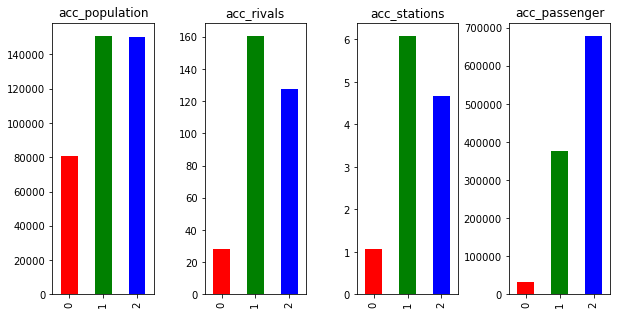

In [24]:
X = tor_mac[['acc_population','acc_rivals','acc_stations','acc_passenger']]
X['cluster'] = ac_labels
result = X.groupby('cluster').mean()
attr_list = ['acc_population','acc_rivals','acc_stations','acc_passenger']

fig, axes = plot.subplots(nrows=1, ncols=4, figsize = (10,5))
plot.subplots_adjust(wspace=0.5)

for idx, entry in enumerate(attr_list):
    df = result[[entry]]
    
    ax = df.plot(kind='bar', ax=axes[idx], title=entry, color = 'rgb')
    ax.set_xlabel(None)
    ax.get_legend().remove()

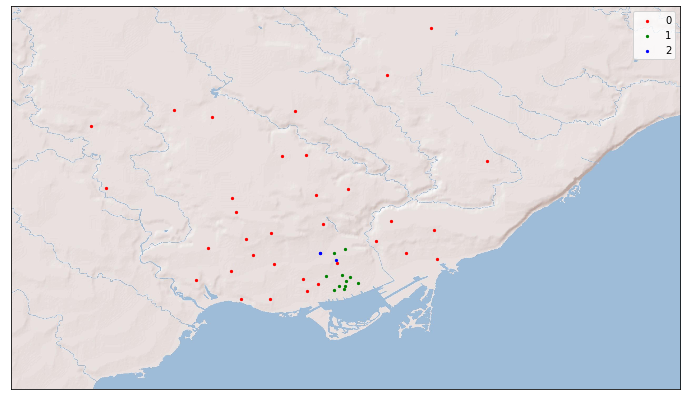

In [25]:
Y = tor_mac.loc[:, ['latitude', 'longitude']]
n_clusters = len(set(ac_labels))
clusters = pd.Series([Y[ac_labels == n] for n in range(n_clusters)])

plot.figure(figsize = (12, 12))
m = Basemap(projection='merc', resolution='l', epsg = 4269, 
            llcrnrlon=-79.597,llcrnrlat=43.58, urcrnrlon=-79.16,urcrnrlat=43.83)
unique_label = np.unique(ac_labels)


# plot different clusters on map, note that the black dots are outliers
for i, cluster in enumerate(clusters):
    lons_select = cluster.iloc[:, 1]
    lats_select = cluster.iloc[:, 0]
    x, y = m(lons_select, lats_select)
    m.scatter(x,y,5,marker='o',color=['r', 'g', 'b'][i], zorder = 10, label=str(i))

m.arcgisimage(service='World_Shaded_Relief', xpixels = 5000, verbose= False)
plot.legend()
plot.show()

From the maps and the attribute bar charts of the clusters in each clustering methodology, we can see 2 clusters might be a better clustering hyperparameter. Also, we could clearly see that both methodologies clustered the McDonald's restaurants to "Downtown Stores" and "Suburb Stores", while the "Suburb Stores" cluster is too spread-out geographically, which is not very informative to help us choosing next store location of McDonald's. Thus, we made a second attempt to cluster the restaurants solely based on their geographical location.

### Location Clustering

We then perform DBSCAN algorithm on location data because DBSCAN can handle both non-linear data and  geodetic distance functions. DBSCAN (Density-Based Spatial Clustering of Application with Noise) is an algorithm that groups together points that are closely packed tougher and maker points as outliers if they lie alone in low-density regions. It has many advantages, such as requiring minimum domain knowledge, no need to specify the number of clusters, able to discover clusters of arbitrary shape, and fast runtime.

The parameters includes:

    1. Eps:
        the maximum distance between two points for them to be considered as in the same cluster. The kilometer per radian on the earth is 6371.0088 and we want to ensure that the maximum distance on earth is 2150m, so eps = 
$\frac{2.15}{6371.0088}$ .

    2. Min_sample:
        the number of minimal points in a cluster for a point to be considered as a center. Here, the minimum is 2.
	
    3. Metric:
        the metric used to calculate the distance between points. Haversine is chosen to ensure that the radial distance is calculated.
        
By the design of this algorithm, some points will be considered as outliers (labeled '0'), meaning that they do not belong to any points. We would treat them as peripheral suburban.

In [26]:
# Run the DBSCAN from sklearn
coords = tor_mac.loc[:, ['latitude', 'longitude']]

kms_per_radian = 6371.0088
epsilon = 2.15 / kms_per_radian    # choose distance of 2150 m
minpts = 2    # at least three points in a cluster

db = DBSCAN(eps=epsilon, min_samples=minpts, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
tor_mac['cluster'] = cluster_labels + 1

Check the outcome of DBSCAN clusters

cluster
5
outlier
6


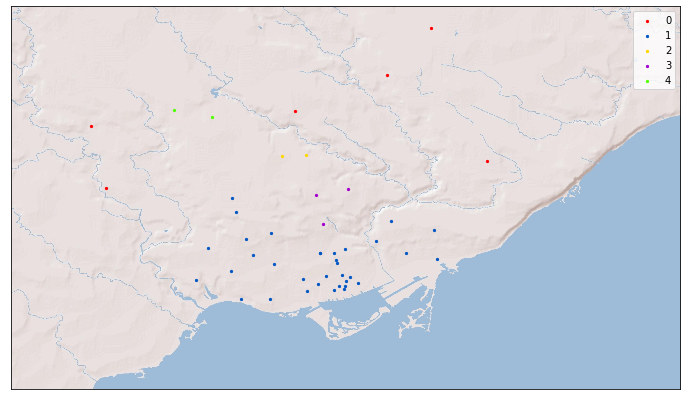

In [27]:
# plot DBSCAN clusters

def get_cmap(N):
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='prism') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color

n_clusters = len(set(cluster_labels))
# get the cluster, 0 means outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, n_clusters)])[:-1]
print("cluster")
print(n_clusters)
print("outlier")
print(sum(cluster_labels==-1))
plot.figure(figsize = (12, 12))
m = Basemap(projection='merc', resolution='l', epsg = 4269, 
            llcrnrlon=-79.597,llcrnrlat=43.58, urcrnrlon=-79.16,urcrnrlat=43.83)
unique_label = np.unique(cluster_labels)

cmaps = get_cmap(n_clusters)

# plot different clusters on map, note that the black dots are outliers
for i, cluster in enumerate(clusters):
    lons_select = cluster.iloc[:, 1]
    lats_select = cluster.iloc[:, 0]
    x, y = m(lons_select, lats_select)
    m.scatter(x,y,5,marker='o',color=cmaps(i), zorder = 10, label=str(i))

m.arcgisimage(service='World_Shaded_Relief', xpixels = 5000, verbose= False)
plot.legend()
plot.show()

Now include the outliers, we have created 6 clusters that emphasized different areas of geographical location. Based on each cluster, we calculated a "saturation" score, defined as:
$$\text{score}_i = 1000 \times\frac{\text{total rivals in each clustered area}}{\text{total residents} + \text{total riders}} \quad\text{for each cluster i}$$
The lower the score means there are more population that can be potentially served by McDonald's stead of other fast food restaurant.

In [28]:
X = tor_mac.loc[:, ['acc_population','acc_rivals','acc_stations','acc_passenger', 'cluster']]
aggX = X.groupby(['cluster']).mean()
aggX['score'] = round(1000 * aggX['acc_rivals'] / (aggX['acc_population'] + aggX['acc_passenger']), 5)
aggX[aggX['score'] == aggX['score'].min()]

,acc_population,acc_rivals,acc_stations,acc_passenger,score
cluster,,,,,
0,52073.166667,5.166667,0.5,25140.833333,0.06691


## 3. Results

Now we identified that the most peripheral suburban areas have the most population that an additional McDonald's restaurant can serve. We then further find a specific area where the new McDonald's restaurant should locate in by calculating the "saturation" score of each residential area that locates within the coverage of cluster labeled '0', and the area with the lowest score should be the one where we open the new McDonald's store.

In [29]:
# find peripheral suburban in residential area data
re_mac = tor_mac[tor_mac['cluster'] == 0]
re_mac.loc[:, ['latitude', 'longitude']].describe()
re_nhh = nhh[(nhh['LONGITUDE'] < -79.285923) & (nhh['LONGITUDE'] > -79.544696) & (
    nhh['LATITUDE'] < 43.815960) & (nhh['LATITUDE'] > 43.711599)]
re_nhh.columns = ['longitude', 'latitude']

In [30]:
# Find low-scored area
re_nhh['mac_count'] = distance_iter(re_nhh, re_mac, agg_attr=False, radius=3000)
re_nhh = re_nhh.merge(prof, how='left', left_index=True, right_index=True).iloc[:, 2:6]
re_nhh = re_nhh.rename(columns={"longitude_y": "longitude", "latitude_y": "latitude"})

re_nhh['rival_count'] = distance_iter(re_nhh, tor_rivals_loc, False, radius=3000)

re_nhh['passenger_count'] = distance_iter(re_nhh, subway_total, 'Total', radius=3000)
re_nhh['score'] = round(1000 * re_nhh['rival_count'] / (re_nhh['Population, 2016'] + re_nhh['passenger_count']), 5)
mn = re_nhh[re_nhh['mac_count'] == 0]['score'].min()
re_nhh[re_nhh['score'] == mn]

,mac_count,longitude,latitude,"Population, 2016",rival_count,passenger_count,score
AREA_NAME,,,,,,,
Downsview-Roding-CFB,0,-79.490497,43.733292,35052.0,5,41599.0,0.06523


Thus, the new McDonald's restaurant should be opened in Downsview area, location shown in the map below.

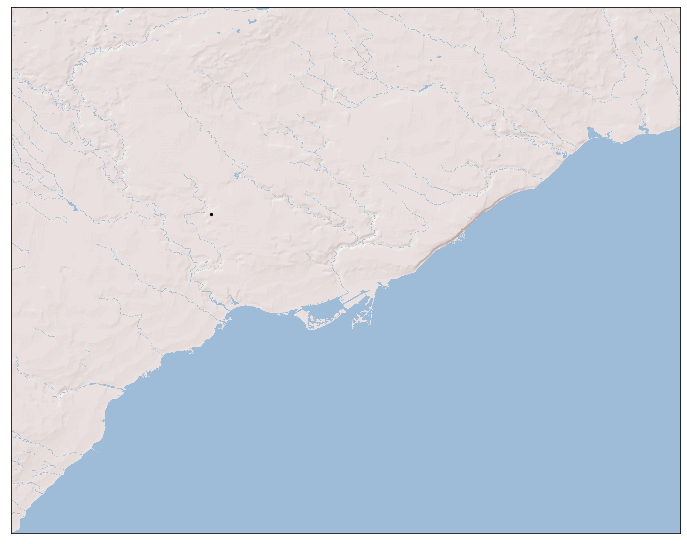

In [31]:
# plot Downsview
plot.figure(figsize = (12, 12))
m = Basemap(projection='merc', resolution='l', epsg = 4269, 
                    llcrnrlon=-79.7,llcrnrlat=43.4, urcrnrlon=-79,urcrnrlat=43.95)

x, y = m(-79.490497, 43.733292)
m.scatter(x,y,5,marker='o', color='black', zorder = 10)

m.arcgisimage(service='World_Shaded_Relief', xpixels = 5000, verbose= False)
plot.show()

## 4. Discussion

Firstly, as the strengths of the study, we have collected very accurate and detailed information about each McDonald's restaurant, rival fast food restaurant, resident area and subway station. Furthermore, we have applied different cluster methodologies in order to find the best explaination of store coverage of each McDonald's restaurant. These attributes all together help us to make robust judgement of the next restaurant location. In addition, the saturation score calculation is very creative, and gives a very practical suggestion on answering the question of where the new store should locate.

Admittedly, the data inputs can be further refined, as now we use the location coordinates of the center of a residential area, and used the subway riders as an approximation of the working population. Ideally, we would get a more accurate population coverage within the distance radius of a McDonald's restaurant. However, we believe the data on hand is the best we can get without actual on-site measurement.

## 5. Conclusion

The problem we had was "where should a new McDonald's restaurant should be opened in the city of Toronto", and we have found the answer through clustering of current restaurant locations, and a score calculation based on the population a restaurant servers and the existance of rival restaurants. Although the population information was limited to be the best approximate of actual population, we still managed to give a practical suggestion.

There are a few different directions that can be worked on in the future following the existing study. Firstly, we may try to collect more attributes of each current restaurant location to help refine the cluster models, such as existance of nearby shopping/site-seeing locations, the accesibility of different forms of traffic (walking, driving), etc. Also, to better answer the business question of opening a new restaurant or not, we can further build models to estimate the revenue and cost to open the restaurant in certain location. Lastly, as more practical next steps, we can do on-site surveys on potential customers and even run test operations to estimate the profitability of new restaurant location.

## Reference

https://medium.com/civic-intelligence/selling-breakfast-smarter-location-intelligence-for-a-global-qsr-sales-strategy-56feb0c2c93b

https://www.yelp.com/dataset

https://open.toronto.ca/dataset/neighbourhoods/ https://open.toronto.ca/dataset/neighbourhood-profiles/ 

https://open.toronto.ca/dataset/ttc-ridership-subway-scarborough-rt-station-usage/

https://janakiev.com/blog/gps-points-distance-python/